<a href="https://colab.research.google.com/github/marant482/MLclass/blob/main/Lab04_penalized-regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework Assignment: Analyzing and Plotting Bias in Penalized Regression**

-------------------------------

In this assignment, you will explore how **Ridge** and **Lasso** regression introduce **bias** into a model to reduce **variance**, and how the choice of the regularization parameter $\lambda$ affects this trade-off. The goal is to visualize and analyze the **bias-variance trade-off** and understand the conditions under which penalization helps or hinders model performance.

## **The Question**

**How does varying the regularization parameter $\lambda$ in Ridge and Lasso regression impact the trade-off between bias and variance?**

- Generate a synthetic dataset based on a **known** linear relationship:
  
  $$
  y = \beta_0 + \beta_1 x + \ldots + \epsilon
  $$

  where $$\epsilon \sim \mathcal{N}(0, \sigma^2),$$

  use a **high-dimensional** setting (e.g., 50 predictors) with only a few non-zero true coefficients to emphasize the effects of regularization. I stress, the $\beta_i$ coefficients should be known for this experiment and they should be mostly 0, with only a few non-zero parameters.

- Investigate how increasing $\lambda$ influences the model’s **bias**, **variance**, and **Mean Squared Error (MSE)**.
- Plot **Bias²**, **Variance**, and **MSE** on a single graph for both Ridge and Lasso models.
- Explain MSE decomposition into bias and variance. Read more on the MSE decomposition if you need to.

**Does the regularization lead to an optimal trade-off point where MSE is minimized? Explain why this point exists.**




**Expected Outcome:**
 - As $\lambda$ increases:
   - **Bias** increases (the model becomes too simple).
   - **Variance** decreases (the model becomes more stable).
   - **MSE** forms a **U-shape**, revealing the optimal trade-off.

- Analyze how **Ridge** and **Lasso** differ in terms of their bias-variance trade-offs.
- Discuss situations where one method may outperform the other, considering factors like **feature sparsity** and **multicollinearity**.


## **Colab Notebook Requirements**
- Your **Colab notebook** should:
  - Simulate the synthetic dataset and apply Ridge and Lasso regression.
  - Plot **Bias²**, **Variance**, and **MSE** against $\lambda$ for both models.
  - Include a section answering the questions.
  - Be well-documented with comments and explanations for each step.


## **Publish on GitHub**
- Upload your Colab notebook to your **GitHub repository** for this course.
- In your repository’s **README**, include a **link** to the notebook.
- In the notebook include **“Open in Colab”** badge so the notebook can be launched directly from GitHub.


Dla każdego punktu, jego oczekiwany błąd Średniokwadratowy można zdekomponować na trzy składniki:

-obciążenie mierzy jak bardzo *średnia* predykcja modelu odbiega od *prawdziwej* wartości funkcji (bez szumu)

-wariancja estymatora, mierzy jak bardzo predykcje modelu dla tego samego punktu różnią się od siebie, w zależności od danych

-wariancja szumu

Do zwizualizowania tej dekompozycji, potrzebujemy wytrenować modele na różnych zbiorach danych, lub na podzielonym zbiorze, a następnie uśrednić wyniki. W tym celu przeprowadzimy 100 symulacji na wygenerowanych zbiorach danych.

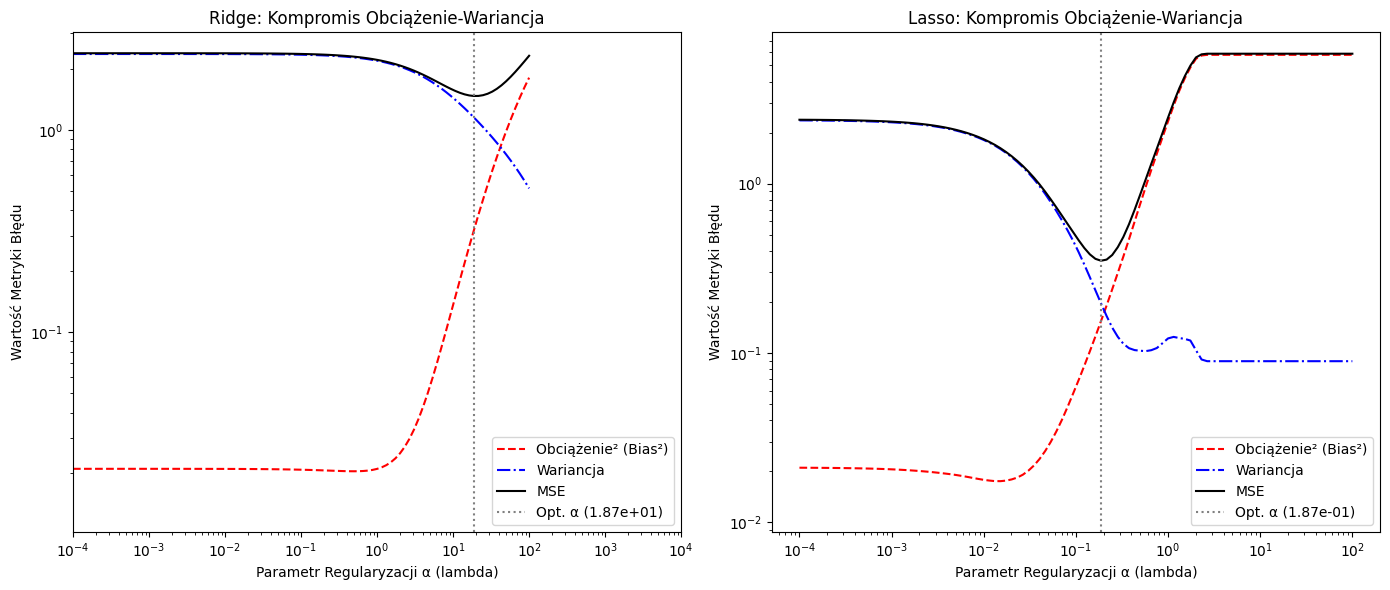


Optymalna alpha dla Ridge: 1.8738e+01
Optymalna alpha dla Lasso: 1.8738e-01


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler # Do skalowania danych
from sklearn.pipeline import Pipeline           # Do łączenia skalowania i modelu
from sklearn.exceptions import ConvergenceWarning
import warnings

# Ignoruj ostrzeżenia o zbieżności dla Lasso, które mogą wystąpić dla małych alpha
warnings.filterwarnings("ignore", category=ConvergenceWarning)


n_samples = 100
n_features = 50
n_informative = 5       # Liczba cech niezerowych
sigma = 1.5
n_simulations = 100     # Liczba symulowanych zbiorów danych do uśrednienia
n_alphas = 100          # Liczba różnych wartości lambda (alpha) do przetestowania
alphas = np.logspace(-4, 2, n_alphas) # Zakres wartości lambda (alpha)

#prawdziwe współczynniki
beta_true = np.zeros(n_features + 1)
beta_true[0] = 1.0
beta_true[1:n_informative + 1] = np.random.uniform(-2, 2, size=n_informative)


#Generowanie Danych
def generate_data(n_samples, n_features, beta_true, sigma):

    X = np.random.randn(n_samples, n_features)
    X_design = np.hstack([np.ones((n_samples, 1)), X]) #jedynki do wyrazu wolnego
    y_noiseless = X_design @ beta_true
    epsilon = np.random.normal(0, sigma, n_samples)
    y_observed = y_noiseless + epsilon
    return X, y_observed, y_noiseless


#zbiór testowy generuję bez szumu
n_test_samples = 1000
X_test, _, y_test_true = generate_data(n_test_samples, n_features, beta_true, sigma=0)


ridge_predictions = np.zeros((n_test_samples, n_simulations, n_alphas))
lasso_predictions = np.zeros((n_test_samples, n_simulations, n_alphas))

#symulacje
for i in range(n_simulations):

    X_train, y_train, _ = generate_data(n_samples, n_features, beta_true, sigma)

    for j, alpha in enumerate(alphas):
        # RIDGE
        ridge_pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('ridge', Ridge(alpha=alpha, fit_intercept=True))
        ])
        ridge_pipe.fit(X_train, y_train)
        ridge_predictions[:, i, j] = ridge_pipe.predict(X_test)

        # LASSO
        lasso_pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('lasso', Lasso(alpha=alpha, fit_intercept=True, max_iter=10000, tol=1e-3))
        ])
        lasso_pipe.fit(X_train, y_train)
        lasso_predictions[:, i, j] = lasso_pipe.predict(X_test)


# Inicjalizacja list na wyniki
ridge_bias_sq = np.zeros(n_alphas)
ridge_variance = np.zeros(n_alphas)
ridge_mse = np.zeros(n_alphas)

lasso_bias_sq = np.zeros(n_alphas)
lasso_variance = np.zeros(n_alphas)
lasso_mse = np.zeros(n_alphas)

# Obliczanie metryk
for j in range(n_alphas):
    #RIDGE
    avg_ridge_pred = np.mean(ridge_predictions[:, :, j], axis=1)
    ridge_bias_sq[j] = np.mean((avg_ridge_pred - y_test_true)**2)
    ridge_variance[j] = np.mean(np.var(ridge_predictions[:, :, j], axis=1))
    ridge_mse[j] = np.mean((ridge_predictions[:, :, j] - y_test_true[:, np.newaxis])**2)


    #LASSO
    avg_lasso_pred = np.mean(lasso_predictions[:, :, j], axis=1)
    lasso_bias_sq[j] = np.mean((avg_lasso_pred - y_test_true)**2)
    lasso_variance[j] = np.mean(np.var(lasso_predictions[:, :, j], axis=1))
    lasso_mse[j] = np.mean((lasso_predictions[:, :, j] - y_test_true[:, np.newaxis])**2)






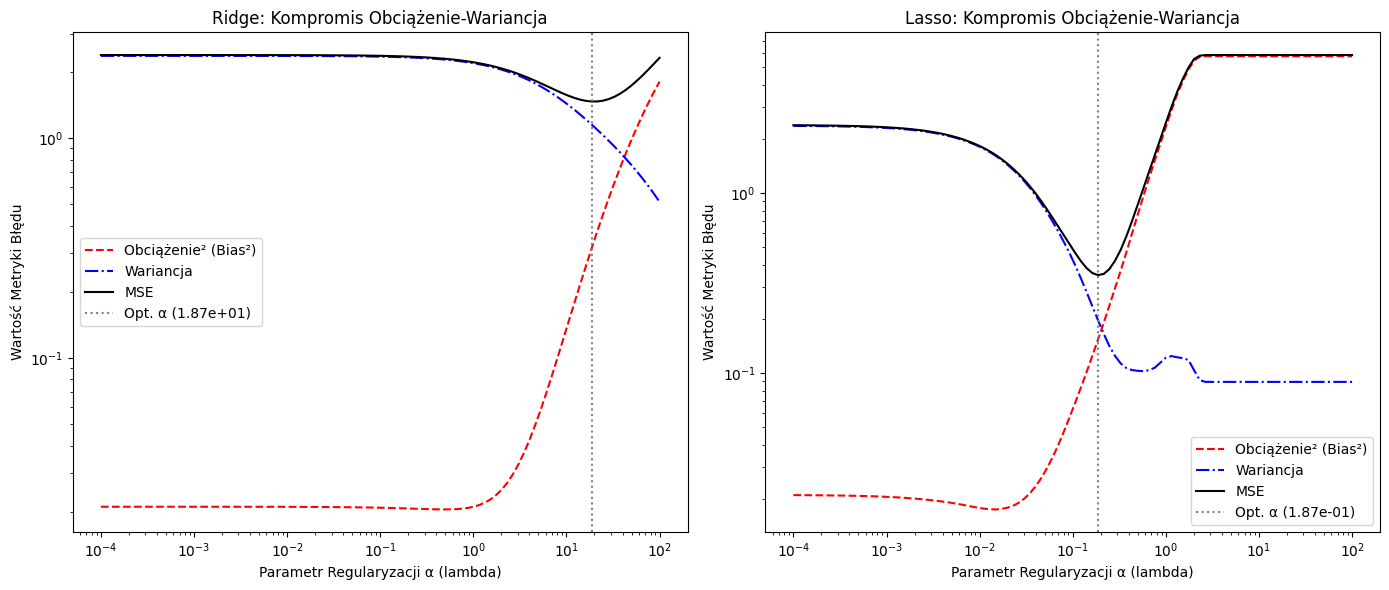


Optymalna alpha dla Ridge: 1.8738e+01
Optymalna alpha dla Lasso: 1.8738e-01


In [14]:
plt.figure(figsize=(14, 6))

#RIDGE WYKRES
plt.subplot(1, 2, 1)
plt.plot(alphas, ridge_bias_sq, 'r--', label='Obciążenie² (Bias²)')
plt.plot(alphas, ridge_variance, 'b-.', label='Wariancja')
plt.plot(alphas, ridge_mse, 'k-', label='MSE')
min_mse_ridge_idx = np.argmin(ridge_mse)
plt.axvline(alphas[min_mse_ridge_idx], color='grey', linestyle=':',
            label=f'Opt. α ({alphas[min_mse_ridge_idx]:.2e})')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Parametr Regularyzacji α (lambda)')
plt.ylabel('Wartość Metryki Błędu')
plt.title('Ridge: Kompromis Obciążenie-Wariancja')
plt.legend()




#LASSO WYKRES
plt.subplot(1, 2, 2)
plt.plot(alphas, lasso_bias_sq, 'r--', label='Obciążenie² (Bias²)')
plt.plot(alphas, lasso_variance, 'b-.', label='Wariancja')
plt.plot(alphas, lasso_mse, 'k-', label='MSE')

min_mse_lasso_idx = np.argmin(lasso_mse)

plt.axvline(alphas[min_mse_lasso_idx], color='grey', linestyle=':',
            label=f'Opt. α ({alphas[min_mse_lasso_idx]:.2e})')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Parametr Regularyzacji α (lambda)')
plt.ylabel('Wartość Metryki Błędu')
plt.title('Lasso: Kompromis Obciążenie-Wariancja')
plt.legend()

plt.tight_layout()
plt.show()

print(f"\nOptymalna alpha dla Ridge: {alphas[min_mse_ridge_idx]:.4e}")
print(f"Optymalna alpha dla Lasso: {alphas[min_mse_lasso_idx]:.4e}")


Na naszych wykresach obliczyliśmy MSE, Obciążenie^2 i Wariancję porównując predykcje z y_test_true, które było *pozbawione szumu* (σ=0 dla zbioru testowego). Dlatego na wykresach suma Obciążenie² + Wariancja powinna być w przybliżeniu równa obliczonemu MSE


Obciążenie:


- Zaczyna od niskiej wartości dla małych α (modele są bliskie OLS, który jest nieobciążony, jeśli model jest poprawnie wyspecyfikowany i mamy wystarczająco danych).
- Rośnie wraz ze wzrostem α. Regularyzacja "ściska" współczynniki w kierunku zera, co upraszcza model. To uproszczenie może powodować, że model systematycznie odbiega od prawdziwej zależności w danych, wprowadzając obciążenie. Dla bardzo dużych α, model staje się trywialny (np. przewiduje tylko średnią), co prowadzi do dużego obciążenia.


Wariancja:
- Zaczyna od wysokiej wartości dla małych α. Szczególnie w naszym przypadku, gdzie tylko 8 na 50 cech ma znaczenie, model bez regularyzacji (lub z małą) jest bardzo elastyczny i dopasowuje się do szumu w konkretnym zbiorze treningowym.
- Maleje wraz ze wzrostem α. Regularyzacja ogranicza złożoność modelu, czyniąc go mniej wrażliwym na szum. Predykcje stają się bardziej stabilne (mniejsza wariancja) między różnymi symulacjami (zbiorami danych)






regularyzacja prowadzi do optymalnego punktu kompromisu, co widać jako minimum na krzywej MSE. Punkt ten istnieje z powodu przeciwstawnych tendencji obciążenia i wariancji w funkcji parametru regularyzacji


Lasso może czasami szybciej redukować wariancję przy małych α, jeśli szybko i poprawnie zidentyfikuje i usunie nieistotne cechy, jednak jego zachowanie może być mniej stabilne niż Ridge, jeśli chodzi o wybór cech (szczególnie przy korelacji). Ridge wykazuje płynniejszy spadek wariancji.

Lasso w naszym przypadku osiąga w najniższym punkcie mniejszy błąd niż ridge, ponieważ mamy bardzo mało istotnych cech, więc jednocześnie bardzo dużo szumu. Lasso zeruje współczynniki tych zmiennych.

Ridge sprawdzi się lepiej:
- spodziewamy się, że większość cech ma pewien wpływ na zmienną objaśnianą, nawet jeśli niektóre wpływy są małe. Lasso mogłoby niesłusznie wyzerować potencjalnie przydatne cechy.
- Gdy występuje silna współliniowość między cechami. Ridge stabilnie rozdziela wpływ między skorelowane predyktory, podczas gdy Lasso ma tendencję do arbitralnego wyboru jednej cechy z grupy skorelowanych i zerowania pozostałych, co czyni wybór cech niestabilnym.



Lasso sprwdzi się lepiej:
- gdy wierzymy, że tylko niewielka liczba cech jest rzeczywiście istotna, tak jak w naszym eksperymencie. Zdolność Lasso do selekcji cech staje się wtedy dużą zaletą, prowadząc do prostszych, bardziej interpreto­walnych modeli i potencjalnie niższej wariancji.
- kiedy interpretowalność modelu i jawna selekcja cech są ważnymi celami.

